In [1]:
import json
import itertools

from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from collections import Counter
from tqdm import tqdm

# 2RCa

## Data loading

In [3]:
with open('2rca_checked_version.json') as f:
    data = json.load(f)

## Data samples

In [4]:
data[0]

{'History': ['Привет, расскажи о себе.',
  'Привет! Под вкусный кофеек настроение поболтать появилось.'],
 'Dia_ID_hash': 'dia_628e79cf',
 'Utt_ID_hash': 'utt_64c12a9b',
 'Phrase': 'Что читаешь? Мне нравится классика. Я тоже люблю пообщаться.',
 'Rewrite': 'Что читаешь? Мне нравится читать классику. Я тоже люблю пообщаться.'}

In [5]:
data[1]

{'History': ['Привет, расскажи о себе.',
  'Привет! Под вкусный кофеек настроение поболтать появилось.',
  'Что читаешь? Мне нравится читать классику. Я тоже люблю пообщаться.'],
 'Dia_ID_hash': 'dia_628e79cf',
 'Utt_ID_hash': 'utt_5cd9dc06',
 'Phrase': 'Люблю животных, просто обожаю, как и свою работу. Я фантастику люблю.',
 'Rewrite': 'Люблю животных, просто обожаю, как и свою работу. Я фантастику читать люблю.'}

In [6]:
data[2]

{'History': ['Привет, расскажи о себе.',
  'Привет! Под вкусный кофеек настроение поболтать появилось.',
  'Что читаешь? Мне нравится читать классику. Я тоже люблю пообщаться.',
  'Люблю животных, просто обожаю, как и свою работу. Я фантастику читать люблю.',
  'А я выращиваю фиалки и веду здоровый и активный образ жизни.'],
 'Dia_ID_hash': 'dia_628e79cf',
 'Utt_ID_hash': 'utt_9d73f6c2',
 'Phrase': 'Ух ты, интересно.',
 'Rewrite': 'Ух ты, интересно, ты фиалки выращиваешь.'}

In [7]:
data[3]

{'History': ['Привет, расскажи о себе.',
  'Привет! Под вкусный кофеек настроение поболтать появилось.',
  'Что читаешь? Мне нравится читать классику. Я тоже люблю пообщаться.',
  'Люблю животных, просто обожаю, как и свою работу. Я фантастику читать люблю.',
  'А я выращиваю фиалки и веду здоровый и активный образ жизни.',
  'Ух ты, интересно, ты фиалки выращиваешь.'],
 'Dia_ID_hash': 'dia_628e79cf',
 'Utt_ID_hash': 'utt_2bfa24e4',
 'Phrase': 'Ты случайно не принц на белом коне? Я его очень жду.',
 'Rewrite': 'Ты случайно не принц на белом коне? Я принца на белом коне очень жду.'}

In [8]:
data[4]

{'History': ['Привет!', 'Привет. Как жизнь?'],
 'Dia_ID_hash': 'dia_ebaf5ccd',
 'Utt_ID_hash': 'utt_63affc77',
 'Phrase': 'Отлично! Солнышко светит, птички поют!',
 'Rewrite': 'Жизнь отлично! Солнышко светит, птички поют!'}

Saving sample of data for manual examination

In [9]:
history, phrase, rewrite = [], [], []

for i in range(100):
    history.append(data[i]["History"])
    phrase.append(data[i]["Phrase"])
    rewrite.append(data[i]["Rewrite"])

In [10]:
pd.DataFrame({"history": history, "phrase": phrase, "rewrite": rewrite}).to_csv("sample_100.csv")

## Statistical Overview of Data

In [11]:
data[0]

{'History': ['Привет, расскажи о себе.',
  'Привет! Под вкусный кофеек настроение поболтать появилось.'],
 'Dia_ID_hash': 'dia_628e79cf',
 'Utt_ID_hash': 'utt_64c12a9b',
 'Phrase': 'Что читаешь? Мне нравится классика. Я тоже люблю пообщаться.',
 'Rewrite': 'Что читаешь? Мне нравится читать классику. Я тоже люблю пообщаться.'}

In [12]:
print("number of dialogs:", len(set(msg['Dia_ID_hash'] for msg in data)))
print("number of phrases:", len(set(msg['Utt_ID_hash'] for msg in data)))

number of dialogs: 1048
number of phrases: 5514


In [13]:
5514 / 1048

5.261450381679389

In [14]:
history_len_msg = [len(msg["History"]) for msg in data]
history_len_chr = [len("".join(msg["History"])) for msg in data]
history_len_wrd = [len("".join(msg["History"]).split()) for msg in data]

In [15]:
pd.Series(history_len_msg).describe()

,0
count,5514.000000
mean,6.372325
std,3.198738
min,1.000000
25%,4.000000
50%,6.000000
75%,9.000000
max,18.000000


In [16]:
pd.Series(history_len_chr).describe()

,0
count,5514.000000
mean,363.195140
std,302.450948
min,7.000000
25%,132.000000
50%,299.000000
75%,506.000000
max,2605.000000


In [17]:
pd.Series(history_len_wrd).describe()

,0
count,5514.000000
mean,56.550961
std,49.036452
min,1.000000
25%,19.000000
50%,46.000000
75%,79.000000
max,401.000000


### Length distribution of original and rewritten utterances



In [18]:
phrase_length_ch = [len(msg['Phrase']) for msg in data]
rephrase_length_ch = [len(msg['Rewrite']) for msg in data]

phrase_length_w = [len(msg['Phrase'].split()) for msg in data]
rephrase_length_w = [len(msg['Rewrite'].split()) for msg in data]

In [19]:
pd.DataFrame({"Длина оригинальной реплики в знаках": phrase_length_ch,
              "Длина восстановленной реплики в знаках": rephrase_length_ch,
              "Длина оригинальной реплики в словах": phrase_length_w,
              "Длина восстановленной реплики в словах": rephrase_length_w}).describe()

,Длина оригинальной реплики в знаках,Длина восстановленной реплики в знаках,Длина оригинальной реплики в словах,Длина восстановленной реплики в словах
count,5514.000000,5514.000000,5514.000000,5514.000000
mean,64.853645,82.460827,11.196409,14.168480
std,57.584832,61.393238,9.687277,10.331881
min,2.000000,7.000000,1.000000,2.000000
25%,25.000000,40.000000,4.000000,7.000000
50%,48.000000,65.500000,9.000000,11.000000
75%,87.000000,106.000000,15.000000,18.000000
max,435.000000,483.000000,72.000000,81.000000


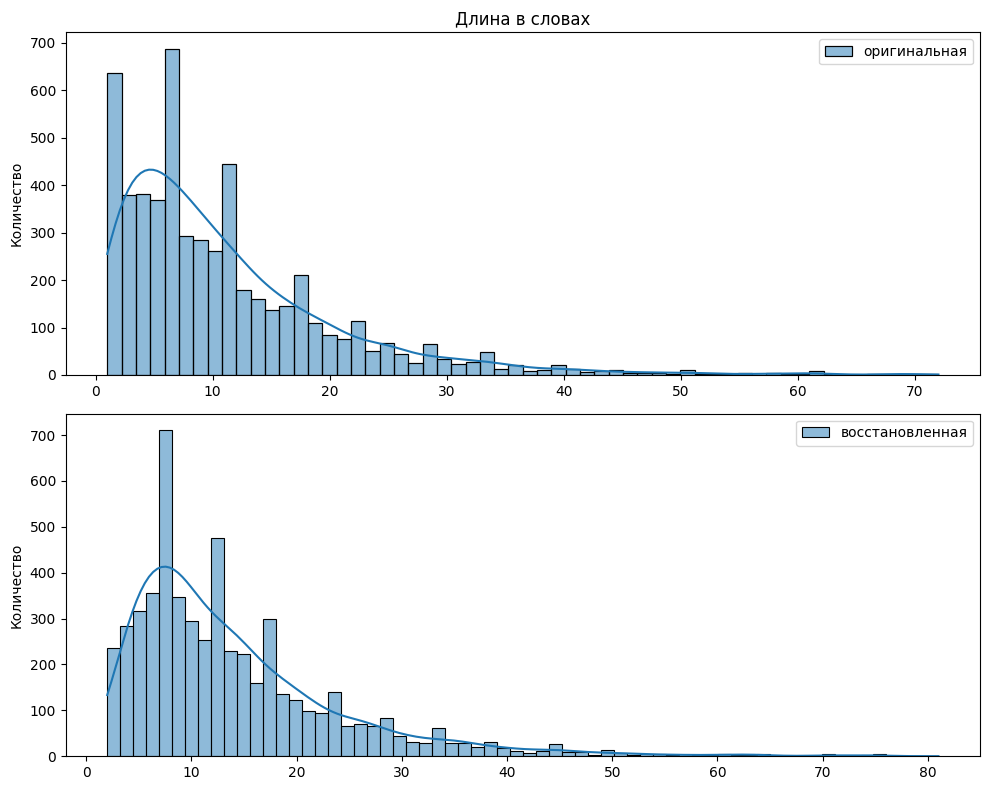

In [20]:
# Create a figure with two subplots arranged vertically
fig, axes = plt.subplots(2, 1, figsize=(10, 8))

# Plot the first histogram (original) on the top subplot
sns.histplot(phrase_length_w, ax=axes[0], kde=True, label='оригинальная', alpha=0.5)
axes[0].set_title('Длина в словах')
axes[0].set_ylabel('Количество')
axes[0].legend()

# Plot the second histogram (rephrased) on the bottom subplot
sns.histplot(rephrase_length_w, ax=axes[1], kde=True, label='восстановленная', alpha=0.5)
axes[1].set_ylabel('Количество')
axes[1].legend()

# Adjust layout and display
plt.tight_layout()
plt.show()

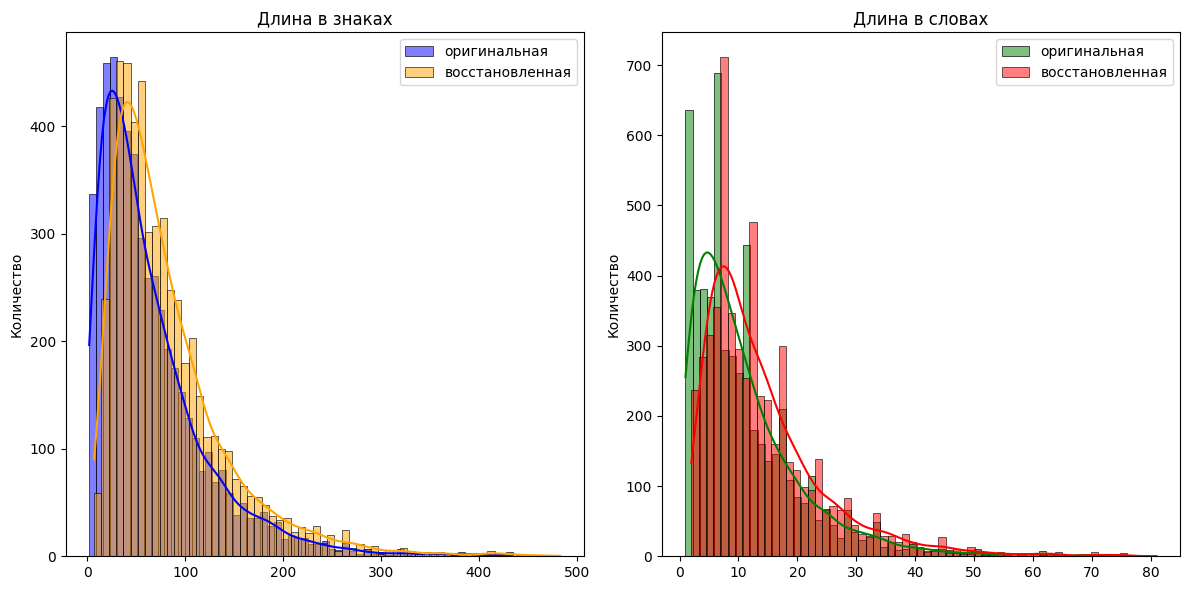

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.histplot(phrase_length_ch, ax=axes[0], color='blue', kde=True, label='оригинальная', alpha=0.5)
sns.histplot(rephrase_length_ch, ax=axes[0], color='orange', kde=True, label='восстановленная', alpha=0.5)
axes[0].set_title('Длина в знаках')
axes[0].set_ylabel('Количество')
axes[0].legend()

sns.histplot(phrase_length_w, ax=axes[1], color='green', kde=True, label='оригинальная', alpha=0.5)
sns.histplot(rephrase_length_w, ax=axes[1], color='red', kde=True, label='восстановленная', alpha=0.5)
axes[1].set_title('Длина в словах')
axes[1].set_ylabel('Количество')
axes[1].legend()

plt.tight_layout()
plt.show()

## Comparison of initial and rewritten messages distributons with SpaCy

### model loading

In [23]:
import spacy


spacy_model = spacy.load("ru_core_news_lg")

### data preprocessing

In [28]:
corpus = []
for sample in data:
    corpus.extend(sample["History"])
    corpus.append(sample["Phrase"])

corpus = list(set(corpus))
corpus = [token.text for doc in corpus for token in spacy_model(doc)]

In [29]:
corpus[0]

'Да'

In [30]:
len(corpus)

214546

In [31]:
len(set(corpus))

13095

In [32]:
corpus = []
for sample in data:
    corpus.extend(sample["History"])
    corpus.append(sample["Phrase"])

corpus = list(set(corpus))
corpus = [token.lemma_ for doc in corpus for token in spacy_model(doc) if not token.is_stop and not token.is_punct]

In [33]:
corpus = [token.lower() for token in corpus]

In [34]:
most_frequent = pd.DataFrame(list(Counter(corpus).items()), columns=['token', 'count']).sort_values(
    by='count', ascending=False).head(100).reset_index(drop=True)

In [36]:
for i in range(len(most_frequent)):
    print(dict(most_frequent.iloc[i])["token"] + " (" + str(int(dict(most_frequent.iloc[i])["count"])) + "),", end=' ')

любить (3933), работать (1571), заниматься (1051), ребёнок (1030), привет (913), время (782), работа (779), животное (714), дело (628), звать (603), жить (602), готовить (532), хобби (516), собака (515), год (489), семья (473), нравиться (398), свободный (383), играть (359), увлекаться (359), жизнь (355), учиться (346), читать (341), обожать (331), кошка (331), путешествовать (329), музыка (323), любимый (311), спорт (311), мечтать (308), какой (305), делать (295), жена (294), город (280), человек (272), школа (269), интересный (259), приятный (258), ходить (258), день (242), хороший (238), муж (237), круто (234), кот (232), смотреть (225), сидеть (224), домашний (222), дом (222), море (219), здоровый (217), отлично (217), профессия (214), сын (213), знать (205), друг (203), книга (198), гулять (196), машина (191), познакомиться (190), крутой (190), мечта (188), увлечение (184), рыбалка (182), два (181), дома (180), учитель (174), думать (170), здорово (166), наверное (163), отличный (

In [37]:
for i in range(len(most_frequent)):
    print(dict(most_frequent.iloc[i])["token"], end=' ')

любить работать заниматься ребёнок привет время работа животное дело звать жить готовить хобби собака год семья нравиться свободный играть увлекаться жизнь учиться читать обожать кошка путешествовать музыка любимый спорт мечтать какой делать жена город человек школа интересный приятный ходить день хороший муж круто кот смотреть сидеть домашний дом море здоровый отлично профессия сын знать друг книга гулять машина познакомиться крутой мечта увлечение рыбалка два дома учитель думать здорово наверное отличный слушать говорить уметь брат москва давать рисовать родитель природа девушка класс мама раз новый ездить женатый замужем настроение пойти дочка вечер рассказать спасибо отдыхать внук гитара игра увлекаешься больший рад 

In [38]:
dict(most_frequent.iloc[0])

{'token': 'любить', 'count': np.int64(3933)}

In [39]:
for row in most_frequent.iterrows():
    print(row)

(0, token    любить
count      3933
Name: 0, dtype: object)
(1, token    работать
count        1571
Name: 1, dtype: object)
(2, token    заниматься
count          1051
Name: 2, dtype: object)
(3, token    ребёнок
count       1030
Name: 3, dtype: object)
(4, token    привет
count       913
Name: 4, dtype: object)
(5, token    время
count      782
Name: 5, dtype: object)
(6, token    работа
count       779
Name: 6, dtype: object)
(7, token    животное
count         714
Name: 7, dtype: object)
(8, token    дело
count     628
Name: 8, dtype: object)
(9, token    звать
count      603
Name: 9, dtype: object)
(10, token    жить
count     602
Name: 10, dtype: object)
(11, token    готовить
count         532
Name: 11, dtype: object)
(12, token    хобби
count      516
Name: 12, dtype: object)
(13, token    собака
count       515
Name: 13, dtype: object)
(14, token    год
count    489
Name: 14, dtype: object)
(15, token    семья
count      473
Name: 15, dtype: object)
(16, token    нравиться
coun

In [40]:
phrase2pos, rewrite2pos = {}, {}


for msg in tqdm(data):
    doc = spacy_model(msg['Phrase'])
    phrase2pos[msg['Phrase']] = [{"text": token.text, "lemma": token.lemma_, "pos": token.pos_, "is_stop": token.is_stop}
                                 for token in doc]

    doc = spacy_model(msg['Rewrite'])
    rewrite2pos[msg['Rewrite']] = [{"text": token.text, "lemma": token.lemma_, "pos": token.pos_, "is_stop": token.is_stop}
                                   for token in doc]

100%|██████████| 5514/5514 [02:50<00:00, 32.25it/s]


In [41]:
row_text_example, res_example = list(phrase2pos.items())[0]

In [42]:
row_text_example

'Что читаешь? Мне нравится классика. Я тоже люблю пообщаться.'

In [43]:
res_example

[{'text': 'Что', 'lemma': 'что', 'pos': 'PRON', 'is_stop': True},
 {'text': 'читаешь', 'lemma': 'читать', 'pos': 'VERB', 'is_stop': False},
 {'text': '?', 'lemma': '?', 'pos': 'PUNCT', 'is_stop': False},
 {'text': 'Мне', 'lemma': 'мне', 'pos': 'PRON', 'is_stop': True},
 {'text': 'нравится', 'lemma': 'нравиться', 'pos': 'VERB', 'is_stop': False},
 {'text': 'классика', 'lemma': 'классика', 'pos': 'NOUN', 'is_stop': False},
 {'text': '.', 'lemma': '.', 'pos': 'PUNCT', 'is_stop': False},
 {'text': 'Я', 'lemma': 'я', 'pos': 'PRON', 'is_stop': True},
 {'text': 'тоже', 'lemma': 'тоже', 'pos': 'ADV', 'is_stop': True},
 {'text': 'люблю', 'lemma': 'любить', 'pos': 'VERB', 'is_stop': False},
 {'text': 'пообщаться',
  'lemma': 'пообщаться',
  'pos': 'VERB',
  'is_stop': False},
 {'text': '.', 'lemma': '.', 'pos': 'PUNCT', 'is_stop': False}]

### most frequent tokens

In [44]:
all_phrase_tokens = [v["lemma"] for v in itertools.chain.from_iterable(phrase2pos.values())
                     if not v["is_stop"] and not v["pos"] == "PUNCT"]

all_rewrite_tokens = [v["lemma"] for v in itertools.chain.from_iterable(rewrite2pos.values())
                     if not v["is_stop"] and not v["pos"] == "PUNCT"]

In [45]:
frequent_tokens_df = pd.DataFrame(Counter(all_phrase_tokens).items()).rename(columns={0: "lemma", 1: "counts"})
frequent_tokens_df = frequent_tokens_df.sort_values(by="counts", ascending=False)
frequent_tokens_df["freq"] = frequent_tokens_df.counts / frequent_tokens_df.counts.sum()
frequent_tokens_df.head(50)

,lemma,counts,freq
3,любить,1320,0.045552
95,-,659,0.022741
41,работать,461,0.015909
49,ребёнок,332,0.011457
134,время,298,0.010284
7,работа,296,0.010215
143,заниматься,276,0.009524
5,животное,232,0.008006
55,жить,204,0.007040
140,готовить,185,0.006384


In [46]:
frequent_tokens_df = pd.DataFrame(Counter(all_rewrite_tokens).items()).rename(columns={0: "lemma", 1: "counts"})
frequent_tokens_df = frequent_tokens_df.sort_values(by="counts", ascending=False)
frequent_tokens_df["freq"] = frequent_tokens_df.counts / frequent_tokens_df.counts.sum()
frequent_tokens_df.head(25)

,lemma,counts,freq
3,любить,1774,0.046293
107,-,809,0.021111
50,работать,724,0.018893
58,ребёнок,576,0.015031
25,заниматься,489,0.012761
5,животное,417,0.010882
7,работа,382,0.009968
148,время,345,0.009003
34,дело,337,0.008794
66,жить,306,0.007985


### PoS distribution

In [47]:
phrase_pos = pd.DataFrame(Counter([v["pos"] for v in itertools.chain.from_iterable(phrase2pos.values()) if v["pos"] != "PUNCT" ]).items())
phrase_pos.rename(columns={0: "pos", 1: "count_original"}, inplace=True)
phrase_pos["freq_original"] = phrase_pos.count_original / phrase_pos.count_original.sum()

In [48]:
rewrite_pos = pd.DataFrame(Counter([v["pos"] for v in itertools.chain.from_iterable(rewrite2pos.values())  if v["pos"] != "PUNCT" ]).items())
rewrite_pos.rename(columns={0: "pos", 1: "count_rewritten"}, inplace=True)
rewrite_pos["freq_rewritten"] = rewrite_pos.count_rewritten / rewrite_pos.count_rewritten.sum()

In [49]:
phrase_pos = phrase_pos[phrase_pos.pos.map(lambda x: x  not in ["SPACE", "X", "SYM"])]
rewrite_pos = rewrite_pos[rewrite_pos.pos.map(lambda x: x  not in ["SPACE", "X", "SYM"])]

In [50]:
res  = phrase_pos.set_index("pos").join(rewrite_pos.set_index("pos"), how="left"
    ).sort_values(by="count_original", ascending=False)

In [51]:
res.freq_original = res.freq_original.map(lambda x: round(x * 100, 2))
res.freq_rewritten = res.freq_rewritten.map(lambda x: round(x * 100, 2))
res["increase"] = (res.count_rewritten - res.count_original) / res.count_rewritten
res.increase = res.increase.map(lambda x: round(x * 100, 2))
res

,count_original,freq_original,count_rewritten,freq_rewritten,increase
pos,,,,,
NOUN,12490,20.07,17349,21.99,28.01
VERB,10975,17.64,14722,18.66,25.45
PRON,9039,14.53,11782,14.93,23.28
ADV,6521,10.48,6866,8.70,5.02
ADP,5978,9.61,8256,10.46,27.59
CCONJ,4099,6.59,4309,5.46,4.87
ADJ,3829,6.15,4500,5.70,14.91
PART,3437,5.52,3762,4.77,8.64
PROPN,1596,2.57,1895,2.40,15.78


In [52]:
(res.count_rewritten - res.count_original) / res.count_rewritten

,0
pos,
NOUN,0.280074
VERB,0.254517
PRON,0.232813
ADV,0.050248
ADP,0.275921
CCONJ,0.048735
ADJ,0.149111
PART,0.086390
PROPN,0.157784


Тут немножко странные результаты: с одной строны становится больше существительных и глаголов, что как будто логично. С другой стороны, местоимений тоже становиться больше

#### visualization

In [ ]:
def filter_rare_tags(counts, pct):
    total_tokens = sum(counts.values())
    filtered_counts = {}
    for tag, count in counts.items():
        if count / total_tokens >= pct / 100:
            filtered_counts[tag] = count
    # Add "Other" category for rare tags
    if len(filtered_counts) < len(counts):  # If there are rare tags
        filtered_counts['Other'] = total_tokens - sum(filtered_counts.values())
    return filtered_counts


def plot_pos_tag_distribution(a_counts, b_counts, a_label, b_label, threshold, figsize):
    # Filter rare tags
    filtered_a_counts = filter_rare_tags(a_counts, threshold)
    filtered_b_counts = filter_rare_tags(b_counts, threshold)

    all_labels = sorted(set([*filtered_a_counts.keys(), *filtered_b_counts.keys()]),
                        key=lambda x: -filtered_a_counts.get(x, 0))

    # Prepare labels and sizes for the pie charts
    a_labels = [l for l in all_labels if l in filtered_a_counts]
    a_sizes = [filtered_a_counts[k] for k in a_labels]

    b_labels = [l for l in all_labels if l in filtered_b_counts]
    b_sizes = [filtered_b_counts[k] for k in b_labels]

    colors = plt.cm.tab20.colors  # Using a colormap with distinct colors

    # Create subplots for side-by-side pie charts
    fig, axs = plt.subplots(1, 2, figsize=figsize)

    # Pie chart for phrase2pos
    axs[0].pie(a_sizes, labels=a_labels,  autopct='%1.1f%%',  startangle=90, colors=colors[:len(a_labels)])
    axs[0].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    axs[0].set_title(a_label)

    # Pie chart for rewrite2pos
    axs[1].pie(b_sizes, labels=b_labels, autopct='%1.1f%%', startangle=90, colors=colors[:len(b_labels)])
    axs[1].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    axs[1].set_title(b_label)

    # Show the pie charts
    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()

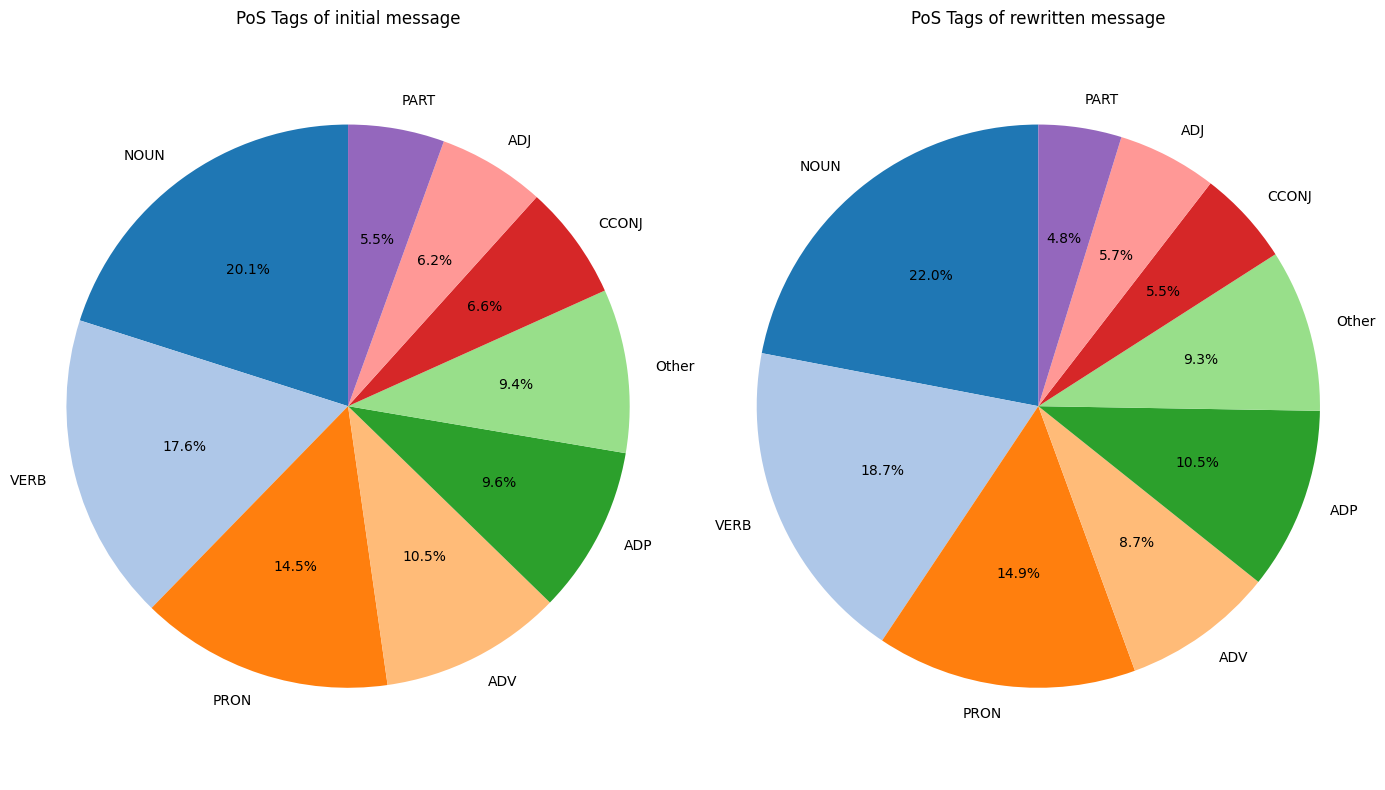

In [54]:
plot_pos_tag_distribution(
    Counter([v["pos"] for v in itertools.chain.from_iterable(phrase2pos.values()) if v["pos"] != "PUNCT" ]),
    Counter([v["pos"] for v in itertools.chain.from_iterable(rewrite2pos.values()) if v["pos"] != "PUNCT" ]),
    a_label='PoS Tags of initial message',
    b_label='PoS Tags of rewritten message',
    threshold=3,
    figsize=(14, 8)
    )

### Syntactical structures

In [55]:
def count_coordinat_conj(sentences):
    cc_count = 0
    for sent in tqdm(sentences):
        doc = spacy_model(sent)
        for token in doc:
            if token.dep_ == "cc":
                cc_count += 1
                break
    return cc_count

In [56]:
def count_sub_clauses(sentences):
    sub_claus_count = 0
    for sent in tqdm(sentences):
        doc = spacy_model(sent)
        for token in doc:
            if token.dep_ == "mark":
                sub_claus_count += 1
                break
    return sub_claus_count

In [57]:
count_sub_clauses([msg['Phrase'] for msg in data])

100%|██████████| 5514/5514 [01:21<00:00, 67.59it/s]


811

In [58]:
count_sub_clauses([msg['Rewrite'] for msg in data])

100%|██████████| 5514/5514 [01:30<00:00, 61.07it/s]


1195

In [59]:
count_coordinat_conj([msg['Phrase'] for msg in data])

100%|██████████| 5514/5514 [01:21<00:00, 67.44it/s]


2883

In [60]:
count_coordinat_conj([msg['Rewrite'] for msg in data])

100%|██████████| 5514/5514 [01:30<00:00, 61.19it/s]


2974

In [61]:
len(data)

5514

In [62]:
def count_dep(sentences):
    counts = Counter()
    for sent in tqdm(sentences):
        doc = spacy_model(sent)
        for token in doc:
            counts[token.dep_] += 1
    return counts

In [70]:
phrase_dep = pd.DataFrame(count_dep([msg['Phrase'] for msg in data]).items())

100%|██████████| 5514/5514 [01:25<00:00, 64.27it/s]


In [71]:
rewrite_dep = pd.DataFrame(count_dep([msg['Rewrite'] for msg in data]).items())

100%|██████████| 5514/5514 [01:30<00:00, 60.73it/s]


In [88]:
phrase_dep.columns = ["dep", "counts"]
phrase_dep = phrase_dep.sort_values(by="counts", ascending=False).reset_index(drop=True)

In [89]:
rewrite_dep.columns = ["dep", "counts"]
rewrite_dep = rewrite_dep.sort_values(by="counts", ascending=False).reset_index(drop=True)

In [93]:
phrase_dep.join(rewrite_dep, lsuffix="_initial_phrase", rsuffix="_rewritten_phrase")

,dep_initial_phrase,counts_initial_phrase,dep_rewritten_phrase,counts_rewritten_phrase
0,punct,19763,punct,21380
1,ROOT,12163,ROOT,12148
2,nsubj,7913,nsubj,11335
3,advmod,7096,case,8463
4,case,6103,advmod,7964
5,obl,4611,obl,7019
6,conj,4169,conj,5170
7,cc,4141,obj,4441
8,obj,3070,cc,4341
9,amod,1828,amod,2423
